In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
transform = transforms.ToTensor()

In [33]:
train_data = datasets.MNIST(root='Data', train=True, download=False, transform=transform, )
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [34]:
test_data = datasets.MNIST(root='Data', train=False, download=False, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [35]:
torch.manual_seed(101)  # for consistent results

part_train = torch.utils.data.random_split(train_data, [10000, len(train_data)-10000])[0]

train_loader = DataLoader(part_train, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [36]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84,64,120,32,40]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],layers[2])
        self.fc4 = nn.Linear(layers[2],layers[3])
        self.fc5 = nn.Linear(layers[3],layers[4])
        self.fc6 = nn.Linear(layers[4],layers[5])
        self.fc7 = nn.Linear(layers[5],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = F.relu(self.fc5(X))
        X = F.relu(self.fc6(X))

        X = self.fc7(X)
        return F.log_softmax(X, dim=1)

In [37]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=120, bias=True)
  (fc5): Linear(in_features=120, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=40, bias=True)
  (fc7): Linear(in_features=40, out_features=10, bias=True)
)

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
import time
start_time = time.time()

epochs = 20
train_losses = []
test_losses = []
train_correct = []
test_correct = []
train_losses_graph = []
test_losses_graph = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%100 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_losses_graph.append(loss.item())
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    
    loss_t = criterion(y_val, y_test).item()
    test_losses_graph.append(loss_t)
    
    test_correct.append(tst_corr.item())
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  100 [ 10000/60000]  loss: 0.68795276  accuracy:  47.820%
epoch:  1  batch:  100 [ 10000/60000]  loss: 0.50649881  accuracy:  82.710%
epoch:  2  batch:  100 [ 10000/60000]  loss: 0.27670825  accuracy:  88.760%
epoch:  3  batch:  100 [ 10000/60000]  loss: 0.31552646  accuracy:  91.140%
epoch:  4  batch:  100 [ 10000/60000]  loss: 0.22343034  accuracy:  93.260%
epoch:  5  batch:  100 [ 10000/60000]  loss: 0.22525068  accuracy:  94.450%
epoch:  6  batch:  100 [ 10000/60000]  loss: 0.19239451  accuracy:  95.290%
epoch:  7  batch:  100 [ 10000/60000]  loss: 0.24752574  accuracy:  96.020%
epoch:  8  batch:  100 [ 10000/60000]  loss: 0.15766323  accuracy:  96.550%
epoch:  9  batch:  100 [ 10000/60000]  loss: 0.06695704  accuracy:  97.370%
epoch: 10  batch:  100 [ 10000/60000]  loss: 0.10612872  accuracy:  97.560%
epoch: 11  batch:  100 [ 10000/60000]  loss: 0.12451027  accuracy:  98.200%
epoch: 12  batch:  100 [ 10000/60000]  loss: 0.05592425  accuracy:  97.980%
epoch: 13  b

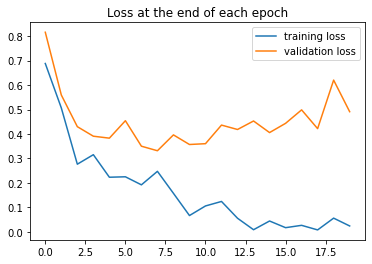

In [40]:
plt.plot(train_losses_graph, label='training loss')
plt.plot(test_losses_graph, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [41]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1]*100/10000:.3f}%') # print the most recent result as a percent

[7738, 8574, 8969, 9125, 9181, 9051, 9253, 9352, 9299, 9360, 9439, 9363, 9407, 9420, 9432, 9457, 9306, 9445, 9317, 9451]

Test accuracy: 94.510%


In [42]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [43]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9451/10000 =  94.510%


In [44]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 955    0    6    0    0    4   16    1    5    9]
 [   0 1117    3    1    2    5    3    4    2    5]
 [   2    3  968    7    9    0    4   18    8    1]
 [   1    4   24  962    0   18    0    8   18    8]
 [   4    0    7    1  928    5   13    4    8   27]
 [   3    1    0   11    1  834   24    4    7    4]
 [   8    2    2    0   16    5  894    0    3    0]
 [   1    2    6    9    0    2    0  943    2    5]
 [   5    6   13   12    5   18    4    2  908    8]
 [   1    0    3    7   21    1    0   44   13  942]]


In [45]:
# 2. deney test accuracy = 94,510

In [ ]:
bir